# Univariate Gaussian Mixture Model

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`


The univariate Gaussian Mixture Model can be represented:

$$\begin{aligned}
    p(s)   &= \mathrm{Bet}(s|\alpha_s, \beta_s) \\
    p(m_{l}) &=  \mathcal{N}(m_l|\mu_l, \sigma_l) \\    
    p(w_{l}) &=  \Gamma(w_l|\alpha_l, \beta_l) \\
    p(z_i) &=  \mathrm{Ber}(z_i|s) \\
    p(y_i) &= \prod_{l=1}^L \mathcal{N}\left(m_{l}, w_{l}\right)^{z_{i}}
\end{aligned}$$


In [2]:
using RxInfer, Random, Plots

In [3]:
@model function gaussian_mixture_model(n)
    
    s ~ Beta(1.0, 1.0)
    
    m1 ~ Normal(mean = -2.0, var = 1e3)
    w1 ~ Gamma(shape = 0.01, rate = 0.01)
    
    m2 ~ Normal(mean = 2.0, var = 1e3)
    w2 ~ Gamma(shape = 0.01, rate = 0.01)
    
    z = randomvar(n)
    y = datavar(Float64, n)
    
    for i in 1:n
        z[i] ~ Bernoulli(s)
        y[i] ~ NormalMixture(z[i], (m1, m2), (w1, w2))
    end
    
end

In [4]:
n = 50

Random.seed!(124)

switch = [ 1/3, 2/3 ]
z      = rand(Categorical(switch), n)
y      = Vector{Float64}(undef, n)

μ1 = -10.0
μ2 = 10.0
w  = 1.777

dists = [
    Normal(μ1, sqrt(inv(w))),
    Normal(μ2, sqrt(inv(w))),
]

for i in 1:n
    global y
    y[i] = rand(dists[z[i]])
end

In [5]:
model = gaussian_mixture_model(length(y))
data  = (y = y,)

initmarginals = (
    s  = vague(Beta), 
    m1 = NormalMeanVariance(-2.0, 1e3), 
    m2 = NormalMeanVariance(2.0, 1e3), 
    w1 = vague(GammaShapeRate), 
    w2 = vague(GammaShapeRate)
)

result = inference(
    model = model, 
    constraints = MeanField(),
    data  = data, 
    initmarginals = initmarginals, 
    iterations  = 10, 
    free_energy = true
)

mswitch = result.posteriors[:s]
mm1 = result.posteriors[:m1]
mm2 = result.posteriors[:m2]
mw1 = result.posteriors[:w1]
mw2 = result.posteriors[:w2]
mz  = result.posteriors[:z]
fe  = result.free_energy;

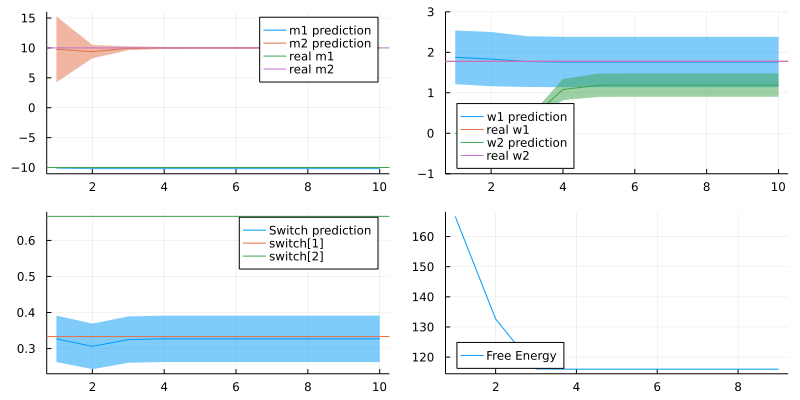

In [6]:
mp = plot(mean.(mm1), ribbon = var.(mm1) .|> sqrt, label = "m1 prediction")
mp = plot!(mean.(mm2), ribbon = var.(mm2) .|> sqrt, label = "m2 prediction")
mp = plot!(mp, [ μ1 ], seriestype = :hline, label = "real m1")
mp = plot!(mp, [ μ2 ], seriestype = :hline, label = "real m2")

wp = plot(mean.(mw1), ribbon = var.(mw1) .|> sqrt, label = "w1 prediction", legend = :bottomleft, ylim = (-1, 3))
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w1")
wp = plot!(wp, mean.(mw2), ribbon = var.(mw2) .|> sqrt, label = "w2 prediction")
wp = plot!(wp, [ w ], seriestype = :hline, label = "real w2")

swp = plot(mean.(mswitch), ribbon = var.(mswitch) .|> sqrt, label = "Switch prediction")

swp = plot!(swp, [ switch[1] ], seriestype = :hline, label = "switch[1]")
swp = plot!(swp, [ switch[2] ], seriestype = :hline, label = "switch[2]")

fep = plot(fe[2:end], label = "Free Energy", legend = :bottomleft)

plot(mp, wp, swp, fep, layout = @layout([ a b; c d ]), size = (800, 400))